# Predicting House Sale Prices

The aim of this project is to predict sale prices for houses using the linear regression model. The data used for the project is housing data for the city of Ames, Iowa, United States from 2006 to 2010. It is available [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). Documentation for the dataset is available [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).
# Explore the Data

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model


df = pd.read_csv("/Users/katestone/Desktop/CSV files/housing.csv")
df.head()

,Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


For each house sold their are 83 columns detailing various features including how big the property is, how many bathrooms it has, how big the garage is, etc. A number of the columns contain missing values and some aren't useful for machine learning. It might also be useful to add some new features, such as the number of years since last remodelling. Lets create a function that will transform all the features and make them easier to work with.

# Transform Features

In [95]:
# Create function that transforms features
def transform_features(df):
    # Drop all columns with 5% missing values
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    # Drop text columns with more than one missing value
    text_null = df.select_dtypes(include=['object']).isnull().sum()
    df = df.drop(text_null[text_null > 0].index, axis=1)
    
    # Numerical cols: For cols with missing vals fill in most common value
    num_null = df.select_dtypes(include=['int', 'float']).isnull().sum()
    num_null_cols = num_null[(num_null > 0) & (num_null < len(df)/20)].sort_values()
    replacement_values_dict = df[num_null_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    # Create new columns and delete old ones
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    ## Drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)

    ## Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    return df

# Apply to df
transform_df = transform_features(df)
transform_df.head()

,Unnamed: 0,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,210,62,0,0,0,0,0,215000,50,50
1,1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,140,0,0,0,120,0,0,105000,49,49
2,2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,393,36,0,0,0,0,12500,172000,52,52
3,3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,0,0,244000,42,42
4,4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,212,34,0,0,0,0,0,189900,13,12


Now that the features have been transformed into a more workable format, lets move on to selecting the best ones to train the model. 

# Select Features
Seeing as SalePrice is what the model is intended to predict, lets identify which columns best correlate with SalePrice. 

In [96]:
# Get an idea of which variables have strong correlation with SalePrice
numerical_df = transform_df.select_dtypes(include=['int', 'float'])
corrmat = numerical_df.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values(ascending=False)
sorted_corrs

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Unnamed: 0           0.031542
Misc Val             0.019273
BsmtFin SF

Quite a number of columns correlate fairly strongly with SalesPrice. For now, let's only keep columns with a correlation coefficent above 0.4. As this cutoff figure is arbitrary it may be worthwhile experimenting with it later.

In [97]:
# Only keep columns with correlation value above 0.4
strong_corrs = sorted_corrs[sorted_corrs > 0.4].sort_values(ascending=False)
transform_df = transform_df.drop(sorted_corrs[sorted_corrs <= 0.4].index, axis=1)

Next, lets plot a heat map to identify potential collinearity between some of these feature columns. If there are two features that convey the same information using two different measures or metrics, it isn't necessary to keep both.

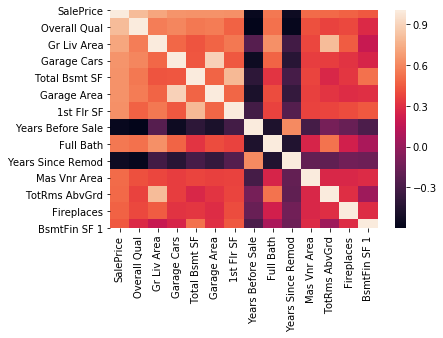

In [98]:
# Plot correlation heat map to identify potential collinearity
%matplotlib inline
corrmat = numerical_df[strong_corrs.index].corr()
sns.heatmap(corrmat)
plt.show()

Looking at the above heat map it is clear the following columns correlate strongly with each other:
- Gr Liv Area and TotRms AbvGrd;
- Garage Area and Garage Cars.

Because Gr Liv Area and Garage Area are continuous variables that capture more nuance, let's drop the TotRms AbvGrd and Garage Cars.

In [99]:
# Drop TotRms AbvGrd and Garage Cars
transform_df = transform_df.drop(columns=["TotRms AbvGrd", "Garage Cars"], axis=1)

Now that the numerical columns have been dealt with, lets take a look at the categorical columns. These columns will need to be transformed using dummy coding in order to be useful for the model. To avoid overcomplicating the model, only features with less that 10 unique values will be used. 

Lets create a function to select and transform the categorical features.

In [100]:
# Create function that selects optimal categorical features
def select_features(df, uniq_threshold=10):
    ## Create a list of column names from documentation that are *meant* to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    ## Identify categorical columns that are still in df 
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)
            
    ## Work out how many unique values in each categorical column?
    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    
    ## Cutoff of 10 unique values
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    ## Select just the remaining text columns and convert to categorical
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
        
    ## Create dummy columns and add back to the dataframe
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

filtered_df = select_features(transform_df)
filtered_df.head()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,Fireplaces,Garage Area,SalePrice,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,6,112.0,639.0,1080.0,1656,1656,1,2,528.0,215000,...,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,0,730.0,105000,...,0,0,0,0,0,0,1,0,0,1
2,6,108.0,923.0,1329.0,1329,1329,1,0,312.0,172000,...,0,0,0,0,0,0,1,0,0,1
3,7,0.0,1065.0,2110.0,2110,2110,2,2,522.0,244000,...,0,0,0,0,0,0,1,0,0,1
4,5,0.0,791.0,928.0,928,1629,2,1,482.0,189900,...,0,0,0,0,0,0,1,0,0,1


# Training and Testing
The final step is to train and test the model. Lets create a train and test function with a parameter named k that controls the type of cross validation that occurs. It will operate as follows:
- When k equals 0, perform holdout validation;
- When k equals 1, perform simple cross validation;
- When k is greater than 0, implement k-fold cross validation using k folds. 

In [105]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)
        return rmse
    
    if k == 1:
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
        
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        avg_rmse = np.mean(rmse_values)
        print(rmse_values)
        return avg_rmse
    
avg_rmse = train_and_test(filtered_df, k=4)
avg_rmse

[24608.689032656057, 37156.67297596957, 28313.149159488195, 25007.017293073422]


28771.382115296812

# Next Steps

Running the model with k = 4 yielded an average rmse value of 28771.4. Next steps to reduce this value even further include:
- Experiment with different k values;
- Experiment with different correlation cut off values;
- Re-evalute the feature selection process;
- Research other approaches to feature engineering around housing data;
- Experiment with other types of models other than Linear Regression. 